In [ ]:
pip install torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Model loaded successfully.


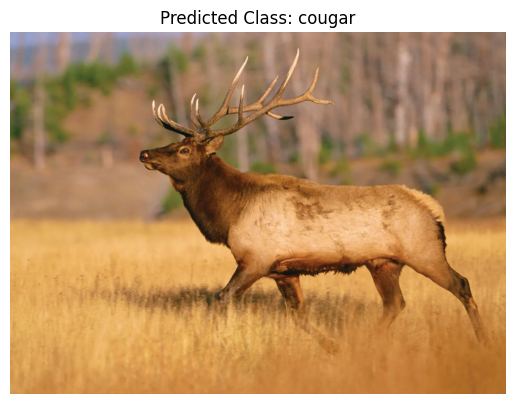

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os

# Define the class names
class_names = [
    'bald_eagle', 'black_bear', 'bobcat', 'canada_lynx', 'columbian_black-tailed_deer',
    'cougar', 'coyote', 'deer', 'elk', 'gray_fox', 'gray_wolf', 'mountain_beaver',
    'nutria', 'raccoon', 'raven', 'red_fox', 'ringtail', 'sea_lions', 'seals', 'virginia_opossum'
]

# Define your model class to match the checkpoint architecture
class SimpleModel(nn.Module):
    def __init__(self, num_classes=20):
        super(SimpleModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(256 * 7 * 7, 512)  # Adjust based on your final feature map size
        self.fc2 = nn.Linear(512, num_classes)  # Adjust according to your number of classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(-1, 256 * 7 * 7)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Path to the saved model checkpoint
checkpoint_path = "wildlife_model_29---20.pt"

# Load the model
def load_model(checkpoint_path, num_classes):
    model = SimpleModel(num_classes=num_classes)
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

        # Different handling based on checkpoint structure
        if 'state_dict' in checkpoint:
            # Standard state_dict checkpoint
            state_dict = checkpoint['state_dict']
        else:
            # Custom checkpoint structure handling (example)
            state_dict = checkpoint

        # Update model state_dict to match current model architecture
        model_dict = model.state_dict()
        pretrained_dict = {k: v for k, v in state_dict.items() if k in model_dict}
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

        model.eval()
        print("Model loaded successfully.")
    else:
        print(f"Checkpoint not found at {checkpoint_path}")
    return model

# Function to predict the class of an image
def predict_image(image_path, model, class_names):
    try:
        # Define image preprocessing pipeline
        preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Load and preprocess the image
        image = Image.open(image_path).convert('RGB')
        input_tensor = preprocess(image)
        input_batch = input_tensor.unsqueeze(0)

        # Make predictions
        with torch.no_grad():
            output = model(input_batch)

        # Get predicted class index
        _, predicted_idx = torch.max(output, 1)
        predicted_idx = predicted_idx.item()

        # Map predicted index to class name
        predicted_class = class_names[predicted_idx]

        # Display the image
        plt.imshow(image)
        plt.axis('off')
        plt.title(f'Predicted Class: {predicted_class}')
        plt.show()

    except Exception as e:
        print(f"Error predicting image: {e}")

# Example usage
if __name__ == "__main__":
    model = load_model(checkpoint_path, num_classes=len(class_names))
    image_path = "/content/elk.jpg"  # Replace with your image path
    predict_image(image_path, model, class_names)


In [ ]:
# Function to test accuracy

def test_accuracy(model, class_names, test_dir):
    checkpoint_path = "wildlife_model_29---20.pt"
    correct = 0
    total = 0
    for class_name in class_names:
        class_dir = os.path.join(checkpoint_path, class_name)
        if not os.path.exists(class_dir):
            continue

        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            predicted_class = predict_image(image_path, model, class_names)
            if predicted_class == class_name:
                correct += 1
            total += 1

    accuracy = correct / total if total > 0 else 0.0
    return accuracy

# Example usage
if __name__ == "__main__":
    accuracy = test_accuracy(model, class_names, checkpoint_path)
    print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 0.00%
